<h1><center><font size="6">Jigsaw EDA</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Jigsaw.svg" width="300"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
    - <a href='#31'>Target feature</a>   
    - <a href='#32'>Sensitive topics features</a>   
    - <a href='#33'>Feedback information</a>   
    - <a href='#34'>Comments data wordclouds</a>   
    - <a href='#35'>Comments data topic modelling</a>  
- <a href='#4'>Prepare the model</a>    
    - <a href='#41'>Build vocabulary</a>   
    - <a href='#42'>Embedding index and embedding matrix</a>   
    - <a href='#43'>Check coverage</a>   
    - <a href='#44'>Transform to lowercase</a>   
    - <a href='#45'>Remove contractions</a>   
    - <a href='#46'>Remove punctuation</a>  
    - <a href='#47'>Tokenize</a>  
- <a href='#5'>References</a>   

# <a id='1'>Introduction</a>  

## Competition objective

The competition objective is to build models that detect toxicity and reduce unwanted bias. 
For example, if a certain minority name is frequently associated with toxic comments, some models might associate the presence of the minority name in a message that is not toxic wiht toxicity and wrongly classify the comment as toxic.

## Background

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

## References

Please consult the <a href='#5'>References</a> section for the datasets, Kernels and articles used in this Kernel. Special mention for tje Kernels of @anebzt [8] and @christofhenkel [9].


# <a id='2'>Prepare the data analysis</a>  

## Load packages

In [1]:
import gc
import os
import warnings
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
from keras.preprocessing.text import Tokenizer

pyLDAvis.enable_notebook()
np.random.seed(2018)
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
Using TensorFlow backend.


## Load data

In [2]:
%%time
JIGSAW_PATH = "../input/jigsaw-unintended-bias-in-toxicity-classification/"
train = pd.read_csv(os.path.join(JIGSAW_PATH,'train.csv'), index_col='id')
test = pd.read_csv(os.path.join(JIGSAW_PATH,'test.csv'), index_col='id')

CPU times: user 15.2 s, sys: 7.69 s, total: 22.9 s
Wall time: 23.1 s


In [3]:
train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
test.head()

In [4]:
print("Train and test shape: {} {}".format(train.shape, test.shape))

Train and test shape: (1804874, 44) (97320, 1)


# <a id='3'>Data exploration</a>  

The comments are stored in `train` and `test` in `comment_text` column.  
Additionally, in `train` we have flags for the presence in the comments of a certain sensitive topic.
The topic is related to five categories: race or ethnicity, gender, sexual orientation, religion, disability, as following:
* **race or ethnicity**: asian, black, jewish, latino, other_race_or_ethnicity, white  
* **gender**: female, male, transgender, other_gender  
* **sexual orientation**: bisexual, heterosexual, homosexual_gay_or_lesbian, other_sexual_orientation  
* **religion**: atheist,buddhist,  christian, hindu, muslim, other_religion  
* **disability**: intellectual_or_learning_disability, other_disability, physical_disability, psychiatric_or_mental_illness  

We also have few article/comment identification information:
* created_date  
* publication_id   
* parent_id  
* article_id 

Several user feedback information associated with the comments are provided:
* rating  
* funny  
* wow  
* sad  
* likes  
* disagree  
* sexual_explicit  

In the datasets are also 2 fields relative to annotations:
* identity_annotator_count  
* toxicity_annotator_count




##  <a id='31'>Target feature</a>

Let's check the distribution of `target` value in the train set.

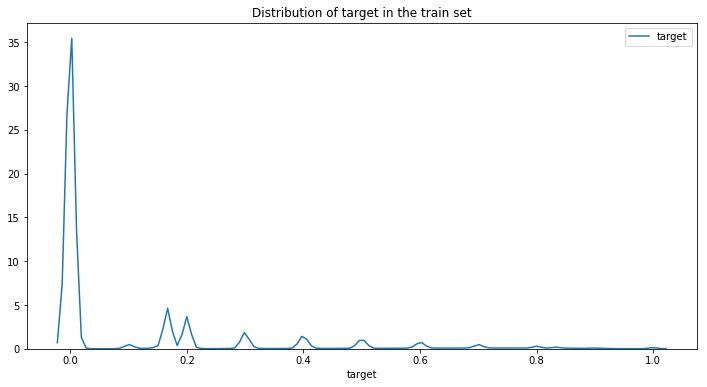

In [5]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(train['target'],kde=True,hist=False, bins=120, label='target')
plt.legend(); plt.show()

And let's represent similarly the distribution of the additional toxicity features.

In [6]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(train[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

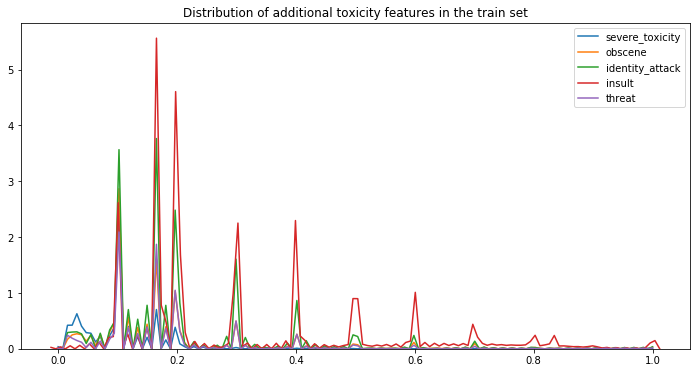

In [7]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

## <a id='32'>Sensitive topics features</a>

Let's check now the distribution of sensitive topics features values.

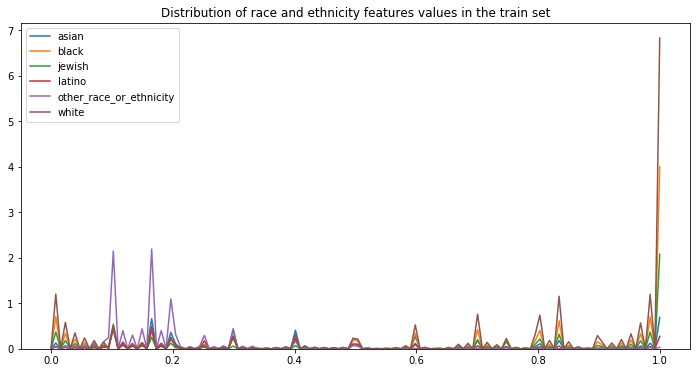

In [8]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

In [ ]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

In [ ]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set")

In [ ]:
features = ['atheist','buddhist',  'christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

In [ ]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

## <a id='33'>Feedback information</a>

Let's show the feedback values distribution.

In [ ]:
def plot_count(feature, title,size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(train))
    g = sns.countplot(train[feature], order = train[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

In [ ]:
plot_count('rating','rating')

In [ ]:
plot_count('funny','funny votes given',3)

In [ ]:
plot_count('wow','wow votes given',3)

In [ ]:
plot_count('sad','sad votes given',3)

In [ ]:
plot_count('likes','likes given',3)

In [ ]:
plot_count('disagree','disagree given',3)

In [ ]:
features = ['sexual_explicit']
plot_features_distribution(features, "Distribution of sexual explicit values in the train set")

## <a id='34'>Comments data wordclouds</a>

Let's show the wordcloud of frequent used words in the comments. A maximum of 50 words are shown.

In [9]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Let's show the prevalent words in the train set (we will use a **20,000** comments sample and show top **50** words).

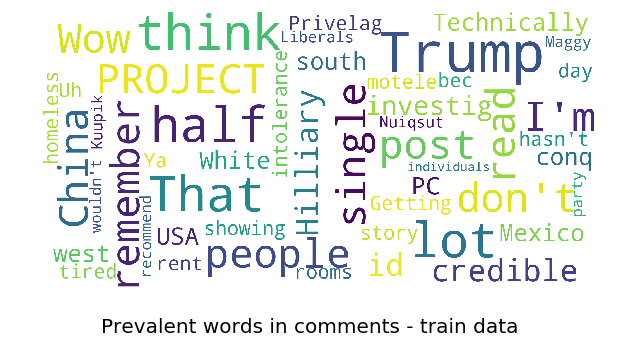

In [10]:
show_wordcloud(train['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

Let's show now the frequent used words in comments for which insult score under **0.25** and above **0.75**.

In [ ]:
show_wordcloud(train.loc[train['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

In [ ]:
show_wordcloud(train.loc[train['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

We show now the most frequent words for comments with threat score bellow **0.25** and above **0.75**.

In [ ]:
show_wordcloud(train.loc[train['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

In [ ]:
show_wordcloud(train.loc[train['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

Let's show the wordcloud of frequent words used in comments with obscene **score < 0.25** and obscene **score > 0.75**.

In [ ]:
show_wordcloud(train.loc[train['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

In [ ]:
show_wordcloud(train.loc[train['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

Let's show now the prevalent words in comments with target (toxicity)  score under **0.25** and over **0.75**.

In [ ]:
show_wordcloud(train.loc[train['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

In [ ]:
show_wordcloud(train.loc[train['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

## <a id='35'>Comments data topic modelling</a>



### Train data

Let's perform topic modelling on a subset of the comments from train data.

In [ ]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

Let's verify the processor for one comment.

In [ ]:
comment_sample = train['comment_text'][:1].values[0]
print('Original comment: {}'.format(comment_sample))
print('Tokenized comment: {}'.format(preprocess(comment_sample)))

Now we will apply preprocess on a sample of 200000 comments.

In [ ]:
%%time
preprocessed_comments = train['comment_text'].sample(200000).map(preprocess)

Let's show few documents preprocessed.

In [ ]:
preprocessed_comments.sample(3)

Let's create now a dictionary. We set also some filters.

In [ ]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

Let's generate a bag-of-words from the dictioanry and the corpus of comments (documents). 
Then, we generate a corpus and apply TF-IDF.

In [ ]:
%%time
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

Let's now run LDA (Latent Dirichelet Allocation algorithm) with the result of TF-IDF applied to the bag-of-words corpus to generate 20 topics.

In [ ]:
%%time
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

Let's represent the first 10 topics, each with 5 words.

In [ ]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Let's use the LDA model to predict the type of topic for one document. 
We select one specific document (with index 5).

In [ ]:
bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

In [ ]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))

We extracted the topics using LDA.
Let's represent the topics using the `pyLDAvis` tool.

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

We save the pyLDAvis graph as a html page.

In [ ]:
pyLDAvis.save_html(vis, "LDAVis_train.html")

To access this page, select **Output** from the side menu of this Notebook.  
Select Press **Download** button next to the **LDAVis_train.html** item to display the widget.

To display this graph widget in the Notebook you will need to uncomment the next cell.

In [ ]:
#vis

### Test data

Let's repeat the same procedure for topic modelling but for test data now.

In [ ]:
%%time
preprocessed_comments = test['comment_text'].map(preprocess)
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
%%time
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

Let's print the top 10 topics, each with 5 words.

In [ ]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Test topic {}: {}".format(i, topic))

We save the pyLDAvis graph as a html page. 

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "LDAVis_test.html")

To access this page, select **Output** from the side menu of this Notebook.  
Select Press **Download** button next to the **LDAVis_test.html**  item to display the widget.

To display this graph widget in the Notebook you will need to uncomment the next cell.

In [ ]:
#vis

# <a id='4'>Prepare the model</a>  

In preparation for the model using Deep Learning, there are two rules formulated by @christofhenkel [8][9]:
* Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings  
* Get your vocabulary as close to the embeddings as possible   



## <a id='41'>Build vocabulary</a>  

We start with building the vocabulary. First we set few constants, as following:  
* **EMBED_SIZE** - embedding size - the size of word vector - should match the embedding source (GloVe);  
* **MAX_FEATURES** - Maximum number of features - the number of unique words to use or number of rows in the embedding vector;  
* **MAXLEN** - The maximum length of comments text

In [11]:
EMBED_SIZE = 300 # size of word vector; this should be set to 300 to match the embedding source
MAX_FEATURES = 100000 # how many unique words to use (i.e num rows in embedding vector)
MAXLEN = 220 # max length of comments text

The following function is from [8][9]. It builds the vocabulary by browsing all comments, splits in sentences, sentences in words. An accumulator is created, with the value associated to each word equal with the accumulated value.

In [12]:
def build_vocabulary(texts):
    """
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: list of list of words
    output: dictionary of words and their count
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in tqdm_notebook(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

We concatenate train and test and build an unique vocabulary with both datasets.

In [13]:
# populate the vocabulary
df = pd.concat([train ,test], sort=False)
vocabulary = build_vocabulary(df['comment_text'])

Let's check the first 10 elements of the vocabulary.

In [14]:
# display the first 10 elements and their count
print({k: vocabulary[k] for k in list(vocabulary)[:10]})

{'This': 128001, 'is': 1534309, 'so': 222618, 'cool.': 501, "It's": 86508, 'like,': 2426, "'would": 14, 'you': 774749, 'want': 101257, 'your': 309675}


## <a id='42'>Embedding index and embedding matrix</a>

Let's build the embedding index (this is a dictionary with keys the embeddings and the values are arrays of their embedding representations) and embedding matrix (a matrix representation of the embeddings).  


In [ ]:
def load_embeddings(file):
    """
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: embeddings file
    output: embedding index
    """
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [ ]:
%%time
GLOVE_PATH = '../input/glove840b300dtxt/'
print("Extracting GloVe embedding started")
embed_glove = load_embeddings(os.path.join(GLOVE_PATH,'glove.840B.300d.txt'))
print("Embedding completed")

Let's check the size of embeeding structure loaded.

In [ ]:
len(embed_glove)

Let's now create the embeeding matrix using the word index and the embeeding index created. We are using the MAX_FEATURES to limit the number of features thus the size of embeeding matrix. 

In [ ]:
def embedding_matrix(word_index, embeddings_index):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: word index, embedding index
    output: embedding matrix
    '''
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    EMBED_SIZE = all_embs.shape[1]
    nb_words = min(MAX_FEATURES, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBED_SIZE))
    for word, i in tqdm_notebook(word_index.items()):
        if i >= MAX_FEATURES:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

## <a id='43'>Check coverage</a>

With the following function, we check coverage of embeddings for the vocabulary created from the train and test dataset. We will sue this function repeatedly after each pre-processing operation.

In [ ]:
def check_coverage(vocab, embeddings_index):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: vocabulary, embedding index
    output: list of unknown words; also prints the vocabulary coverage of embeddings and the % of comments text covered by the embeddings
    '''
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in tqdm_notebook(vocab.keys()):
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print('Found embeddings for {:.3%} of vocabulary'.format(len(known_words)/len(vocab)))
    print('Found embeddings for {:.3%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

Let's check the initial coverage of vocabulary.

In [ ]:
print("Verify the intial vocabulary coverage")
oov_glove = check_coverage(vocabulary, embed_glove)

Embedding only cover ~15% of the vocabulary and this accounts for 89.6% from the entire comments texts.  
Let's check what kind of words are missing from the embeddings.

In [ ]:
oov_glove[:10]

Most of the missing words are punctuation and upper case words. Let's remove punctuation and apply lowerisation (i.e. turn all words to lowercase).

## <a id='44'>Transform to lowercase</a>

In [ ]:
def add_lower(embedding, vocab):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: vocabulary, embedding matrix
    output: modify the embeddings to include the lower case from vocabulary
    '''
    count = 0
    for word in tqdm_notebook(vocab):
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: x.lower())
test['comment_text'] = test['comment_text'].apply(lambda x: x.lower())

In [ ]:
print("Check coverage for vocabulary with lower case")
oov_glove = check_coverage(vocabulary, embed_glove)
add_lower(embed_glove, vocabulary) # operates on the same vocabulary
oov_glove = check_coverage(vocabulary, embed_glove)

Let's check again the words not included in embeddings.

In [ ]:
oov_glove[:10]

We can observe that most of the remaining include contractions and words with punctuation. We continue with removing contractions.

## <a id='45'>Remove contractions</a> 

Contractions are modified forms of words and expressions. We will map, using the following dictionary, the contracted forms on words existent in embeddings.



In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
len(contraction_mapping)

In [ ]:
def known_contractions(embed):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: embedding matrix
    output: known contractions (from embeddings)
    '''
    known = []
    for contract in tqdm_notebook(contraction_mapping):
        if contract in embed:
            known.append(contract)
    return known

In [ ]:
print("Known contractions in GloVe embeddings:")
print(known_contractions(embed_glove))

In [ ]:
def clean_contractions(text, mapping):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: current text, contraction mappings
    output: modify the comments to use the base form from contraction mapping
    '''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

We will build again the vocabulary and check again the coverage.

In [ ]:
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check embeddings after applying contraction mapping")
oov_glove = check_coverage(vocab, embed_glove)

In [ ]:
oov_glove[:10]

It seems that, with lowercase transformation and contraction treatment, the improvement in termns of coverage is not significant. Punctuation, which we didn't treated yet, seems to be really important.

## <a id='46'>Remove punctuation</a>  

We remove as well punctuation.

In [ ]:
punct_mapping = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping += '©^®` <→°€™› ♥←×§″′Â█½à…“★”–●â►−¢²¬░¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸¾Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡√'

def unknown_punct(embed, punct):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: current text, contraction mappings
    output: unknown punctuation
    '''
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [ ]:
print("Find unknown punctuation:")
print(unknown_punct(embed_glove, punct_mapping))

In [ ]:
puncts = {"‘": "'", "´": "'", "°": "", "€": "e", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '…': ' '}

def clean_special_chars(text, punct, mapping):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: current text, punctuations, punctuation mapping
    output: cleaned text
    '''
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ') 
    return text

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, puncts))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_special_chars(x, punct_mapping, puncts))

Let's rebuid the vocabulary after replacing the punctuation and check again the coverage.

In [ ]:
%%time
df = pd.concat([train ,test], sort=False)
vocab = build_vocabulary(df['comment_text'])
print("Check coverage after punctuation replacement")
oov_glove = check_coverage(vocab, embed_glove)

In [ ]:
oov_glove[:10]

There is a significant improvement by extracting punctuation. 99.7% from the text is covered by the embeddings and 57% of the vocabulary. Punctuation appears to be very important.

## <a id='47'>Tokenize</a>

We apply tokenization for train and test. 

In [ ]:
%%time
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(train))
train = tokenizer.texts_to_sequences(train)
test = tokenizer.texts_to_sequences(test)

We are now ready to create a model. Stay tuned!

# <a id='5'>References</a>  

[1] https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/  
[2] https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24  
[3] https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d  
[4] https://www.aclweb.org/anthology/W14-3110   
[5] https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/  
[6] https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets  
[7] https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation  
[8] https://www.kaggle.com/anebzt/quora-preprocessing-model  
[9] https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings  



